#NASLib Hands-On

##Welcome to the NASLib tutorial 📖
This notebook is part of the **NASLib Hands-On Session** for the [2nd AutoML Fall school](https://sites.google.com/view/automl-fall-school-2022). Before you start, please copy this notebook to your Google drive (`File` ➡ `Save a Copy in Drive`).

Here you will learn the following:

  1. 
  2. 
  3. 


# Setup NASLib 

In [1]:
#Setup NASLib
%cd /content
%rm -rf NASLib
!git clone -b Develop_copy https://github.com/automl/NASLib/
%cd /content/NASLib
!pip install -e . --quiet
# The runtime would be automatically restarted now. Just proceed with running the next cell 

/content
Cloning into 'NASLib'...
remote: Enumerating objects: 31957, done.
remote: Counting objects: 100% (1926/1926), done.
remote: Compressing objects: 100% (760/760), done.
remote: Total 31957 (delta 1189), reused 1841 (delta 1115), pack-reused 30031
Receiving objects: 100% (31957/31957), 549.05 MiB | 20.84 MiB/s, done.
Resolving deltas: 100% (22582/22582), done.
/content/NASLib


In [2]:
# Download benchmarks
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 Imagenet16-120
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201


dataset = cifar10
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1sh8pEhdrgZ97-VFBVL94rI36gedExVgJ
To: /content/NASLib/naslib/data/nb201_cifar10_full_training.pickle
100% 117M/117M [00:10<00:00, 10.8MB/s]
dataset = cifar100
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1hV6-mCUKInIK1iqZ0jfBkcKaFmftlBtp
To: /content/NASLib/naslib/data/nb201_cifar100_full_training.pickle
100% 117M/117M [00:01<00:00, 105MB/s] 
dataset = Imagenet16-120
search_space = nb201
dataset = cifar10
search_space = nb301
Downloading...
From: https://drive.google.com/uc?id=1YJ80Twt9g8Gaf8mMgzK-f5hWaVFPlECF
To: /content/NASLib/naslib/data/nb301_full_training.pickle
100% 22.3M/22.3M [00:00<00:00, 94.4MB/s]
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1k2EUtVJ4JqoJCnuyJEVgZs6vAmbg6XVB
To: /content/NASLib/naslib/data/zc_nasbench201.json
100% 44.3M/44.3M [00:00<00:00, 91.8MB/s]


In [3]:
# Import the search space
from naslib.search_spaces import NasBench201SearchSpace

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
# Create a new search space object. This object doesn't have an architecture
# assigned to it yet
graph = NasBench201SearchSpace(n_classes=10)

In [5]:
# Sample a random architecture
# You can call this method only once.
graph.sample_random_architecture()
graph.parse()
# Get the NASLib representation of this architecture
graph.get_hash()

(2, 0, 1, 3, 4, 0)

In [6]:
# This graph is now a NAS-Bench-201 model, which can be used for training
# Forward pass some dummy data through it to see it in action

import torch

x = torch.randn(5, 3, 32, 32) # (Batch_size, Num_channels, Height, Width)

logits = graph(x)

print(logits.shape)

torch.Size([5, 10])


In [7]:
# Import code to convert NASLib graph to the original NAS-Bench-201 representation
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str as convert_naslib_nb201_to_str

# Get the string representation of this model
convert_naslib_nb201_to_str(graph)

'|nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|'

In [8]:
# Mutating an architecture
# First, create a new child_graph
child_graph = NasBench201SearchSpace(n_classes=10)

# Call mutate on the child graph by passing the parent graph to it
child_graph.mutate(parent=graph)

# See the parent and child graph representations
print(f'Parent graph: {graph.get_hash()}')
print(f'Child graph : {child_graph.get_hash()}')

Parent graph: (2, 0, 1, 3, 4, 0)
Child graph : (0, 0, 1, 3, 4, 0)


In [9]:
# Now, let's load the queryable tabular NAS-Bench-201 API
# This API has the training metrics of all the 15625 models in the search space
# such as train and validation accuracies/losses at every epoch

from naslib.utils import get_dataset_api
benchmark_api = get_dataset_api(search_space='nasbench201', dataset='cifar10')

In [10]:
# With the NAS-Bench-201 API, we can now query, say, the validation performance of any NB201 model
# Without it, we would have to train the model from scratch to get this information

# First, import the Metric enum
from naslib.search_spaces.core import Metric

# Metric has, among others, these values:
# Metric.TRAIN_ACCURACY
# Metric.VAL_ACCURACY
# Metric.TRAIN_LOSS
# Metric.TEST_LOSS
# Metric.TRAIN_TIME

train_acc_parent = graph.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=benchmark_api)
val_acc_parent = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=benchmark_api)

print('Performance of parent model')
print(f'Train accuracy: {train_acc_parent}%')
print(f'Validation accuracy: {val_acc_parent}%')

# TODO: Query the train and validation performance of the child model
# train_acc_parent = ...
# val_acc_parent = ...

# print('Performance of child model')
# print(f'Train accuracy: {train_acc_child}')
# print(f'Validation accuracy: {val_acc_child}')

Performance of parent model
Train accuracy: 99.956%
Validation accuracy: 89.82%


In [11]:
# TODO: 
# 1. Sample a random NAS-Bench-301 model
# 2. Get the NASLib and genotype representations of the model
# 3. Query the predicted performance of the model (loading the NB301 benchmark API might take some time)
# 4. Mutate the model
# 5. Get the NASLib and genotype representations of the model
# 6. Query the predicted performance of the child

from naslib.search_spaces import NasBench301SearchSpace
from naslib.search_spaces.nasbench301.conversions import convert_naslib_to_genotype as convert_naslib_nb301_to_genotype

##NAS Optimizers 📈
❓ **Why:** Given the plethora of benchmarks we now want to search for the optimal architectures

📓 **What:** Getting familiar with the different black-box optimizers in NASLib

  1. [Random search (RS)](https://arxiv.org/pdf/1902.07638.pdf) on different NAS benchmarks
  2. Switching to [Regularized Evolution (RE)](https://arxiv.org/pdf/1802.01548.pdf) and [BANANAS](https://arxiv.org/pdf/1910.11858.pdf)
  3. Using BANANAS with multiple [NAS predictors](https://arxiv.org/pdf/2104.01177.pdf)

✅ **Outcome:** Questions to be discussed:

  1. Are RE and BANANAS better than RS?
  2. How do the preformance predictors compare to each other?
  3. Can we extend the optimizers to other benchmarks?

##Random Search
1. Sample an architecture for every epoch and compute its validation error 
2. Select the architecture with the lowest validation error and return its test error 

In [12]:
def update_config(config, optimizer_type, search_space_type, dataset, seed):
    '''
      Update the experiment configs
      optimizer_type: The type of naslib optimizer selected for search (eg: RandomSearch)
      search_space_type: The type of search space used (eg: NasBench201SearchSpace)
      dataset: cifar10,cifar100->NASBench201SearchSpace, cifar10->NASBench301SearchSpace
    '''
    # Dataset being used
    config.dataset = dataset
    
    # Directory to which the results/logs will be saved
    config.save = f"runs/{optimizer_type.__name__}/{search_space_type.__name__}/{dataset}/{seed}"
    
    # Seed used during search phase of the optimizer
    config.search.seed = seed
    
def run_optimizer(optimizer_type, search_space_type, dataset, config, seed): #TODO remove dataset_api
    '''
      Run the optimizer on a NAS benchmark
      1. Instantiate the search space
      2. Get the benchmark API
      3. Instantiate the optimizer and adapat the search space to the optimizer
      4. Create a Trainer
      5. Perform the search and return the best model
      6. Evaluate the best model on the test set
    '''
    # Update the config
    update_config(config, optimizer_type, search_space_type, dataset, seed)

    # Make the results directories
    os.makedirs(config.save + '/search', exist_ok=True)
    os.makedirs(config.save + '/eval', exist_ok=True)

    # Set up the loggers
    logger = setup_logger()
    logger.setLevel(logging.INFO)

     # See the config
    logger.info(f'Configuration is \n{config}')

    # Set up the seed
    utils.set_seed(seed)
    # Instantiate the search space
    n_classes = {
        'cifar10': 10,
        'cifar100': 100,
        'ImageNet16-120': 120
    }
    search_space = search_space_type(n_classes=n_classes[dataset])
    search_space.instantiate_model = False
    # Get the benchmark API
    logger.info('Loading Benchmark API')
    dataset_api = get_dataset_api(search_space.get_type(), dataset)
    
    # Instantiate the optimizer and adapat the search space to the optimizer
    optimizer = optimizer_type(config)
    optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

    # Create a Trainer
    trainer = Trainer(optimizer, config)

    # Perform the search
    trainer.search(report_incumbent=False)

    # Get the results of the search
    search_trajectory = trainer.search_trajectory
    print('Train accuracies:', search_trajectory.train_acc)
    print('Validation accuracies:', search_trajectory.valid_acc)
    # Get the validation performance of the best model found in the search phase
    best_model_val_acc = trainer.evaluate(dataset_api=dataset_api, metric=Metric.VAL_ACCURACY)
    best_model_val_acc

    best_model = optimizer.get_final_architecture()

    return search_trajectory, best_model, best_model_val_acc

In [13]:
# Plotting utilities 
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import FormatStrFormatter

# plot performance vs runtime
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = 'dotted'
# set up colors and plot markings
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
c_max = 9
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-'] * c_max, *['--'] * c_max, *[':'] * c_max]
markers = [*['^'] * c_max, *['v'] * c_max, *['o'] * c_max]


def get_results(results, metric='valid_acc', dataset='cifar10', ug=False):
    '''
      Get the results from the search ready for plotting
    '''
    output = []
    time = []
    for result in results:
        val_acc = result['valid_acc']
        surr_time = np.array(result['runtime'])
        if ug:
            runtime = 200 * np.array(result['train_time']) + surr_time
        else:
            runtime = np.array(result['train_time']) + surr_time
        val_err = [100 - x for x in val_acc]
        val_incumbent = [
            min(val_err[:epoch]) for epoch in range(1,
                                                    len(val_err) + 1)
        ]
        runtime = [
            sum(runtime[:epoch]) for epoch in range(1,
                                                    len(runtime) + 1)
        ]
        if metric == 'valid_acc':
            incumbent = val_incumbent
        elif metric == 'test_acc':
            test_err = [100 - x for x in result['test_acc']]
            inc_idx, best, best_idx = [], np.inf, 0
            for i, err in enumerate(val_err):
                if err < best:
                    best, best_idx = err, i
                    inc_idx.append(best_idx)
                    incumbent = [test_err[idx] for idx in inc_idx]
        output.append(incumbent)
        time.append(runtime)
    output = np.array(output)
    time = np.array(runtime)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(
        np.var(output, axis=0, ddof=1) / np.asarray(output).shape[0])
    return mean, std, std_error, time


def plot_optimizers(trajectories):
    '''
      Plot plot performance vs runtime for different optimizers
      trajectories: Dictionary containing multi-ssed runs of different optimizers 
      and predictors
    '''
    plot_zoomed = False
    plot_sem = True
    fig, ax = plt.subplots(figsize=[10, 5])
    if plot_zoomed:
        sub_axes = plt.axes([.6, .6, .25, .25])
    i = 0
    for optimizer in trajectories.keys():
        mean, std, std_error, time = get_results(trajectories[optimizer])
        results_dict = {}
        results_dict = {
            'label': optimizer,
            'mean': mean,
            'runtime': time,
            'std_error': std_error
        }
        mean = results_dict['mean']
        #print(mean.shape)
        x = results_dict['runtime']
        #print(x.shape)
        sem = results_dict['std_error']
        #print(sem.shape)
        label = results_dict["label"]
        ax.plot(x, mean, label=label, color=colors[i], linestyle=fmts[i])
        ax.fill_between(x,
                        mean - 1 * sem,
                        mean + 1 * sem,
                        color=colors[i],
                        alpha=0.2)
        i = i + 1
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xscale('log')
    ax.legend(loc=(1.04, 0))
    ax.set_xlabel('Runtime [s] (simulated)')
    ax.set_ylabel('Test error (%)')
    ax.grid(True, which="both", ls="-", alpha=.5)
    ax.set_title('Test error vs. train time on NAS-Bench-201')


  


In [15]:
#initialize trajectories which will be populated througout the notebook
trajectories = {}

In [18]:
# Set the optimizer and search space types
# They will be instantiated inside run_optimizer
optimizer_type = RandomSearch # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config = {
    'search': {
        # Required by Trainer
        'epochs': 200,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode.load_cfg(json.dumps(config))
#Initialize trajectories for the 3 seeds
trajectories["RS"] = []
for seed in [333,444,555]: #Run RS for 3 seeds
  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed,
                                                    )
  trajectories["RS"].append(search_trajectory)

[10/07 14:51:26 naslib]: Configuration is 
dataset: cifar10
save: runs/RandomSearch/NasBench201SearchSpace/cifar10/333
search:
  checkpoint_freq: 100
  epochs: 200
  fidelity: -1
  population_size: 30
  sample_size: 10
  seed: 333
[10/07 14:51:27 naslib]: Loading Benchmark API
[10/07 14:51:28 nl.defaults.trainer]: param size = 0.000000MB
[10/07 14:51:28 nl.defaults.trainer]: Start training
[10/07 14:51:28 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/07 14:51:28 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/07 14:51:28 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/07 14:51:28 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[10/07 14:51:29 nl.defaults.trainer]: Epoch 4 done. Train accuracy: 99.92000, Validation accuracy: 89.14000
[10/07 14:51:29 nl.defaults.trainer]: Epoch 5 done. Train accuracy:

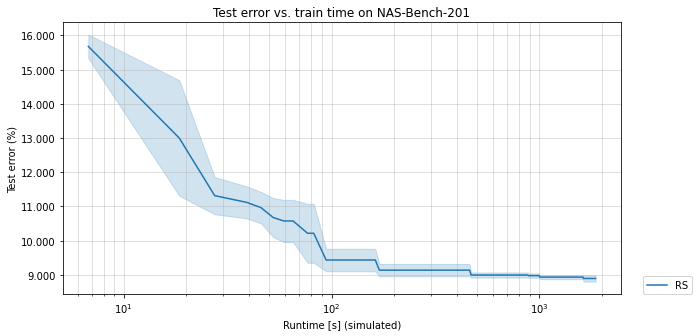

In [19]:
# Plot RS for three seeds
plot_optimizers(trajectories)

## Regularized Evolution

In [ ]:
# TODO:
# 1. Use the Regularized Evolution optimizer instead of RandomSearch (hint: Change just one line of code)
# 2. Use the NASBench301SearchSpace for cifar100 -> TODO replace with TNB101 (hint: Change just two lines of code)

# Set the optimizer type
optimizer_type = ...
# Set the search space type
search_space_type = ...

# Set the dataset
dataset = ... 

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config = {
    'search': {
        # Required by Trainer
        'epochs': 200,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode.load_cfg(json.dumps(config))
#Initialize trajectories for the 3 seeds
trajectories["RE"] = []
for seed in [333,444,555]: #Run RS for 3 seeds
  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed
                                                    )
  trajectories["RE"].append(search_trajectory)

[10/07 12:13:37 naslib]: Configuration is 
dataset: cifar10
save: runs/RegularizedEvolution/NasBench201SearchSpace/cifar10/333
search:
  checkpoint_freq: 100
  epochs: 100
  fidelity: -1
  population_size: 30
  sample_size: 10
  seed: 333
[10/07 12:13:38 naslib]: Loading Benchmark API
[10/07 12:13:39 nl.defaults.trainer]: param size = 0.000000MB
[10/07 12:13:39 nl.defaults.trainer]: Start training
[10/07 12:13:39 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[10/07 12:13:39 nl.optimizers.discrete.re.optimizer]: Population size 1
[10/07 12:13:39 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/07 12:13:39 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[10/07 12:13:40 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/07 12:13:40 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the popu

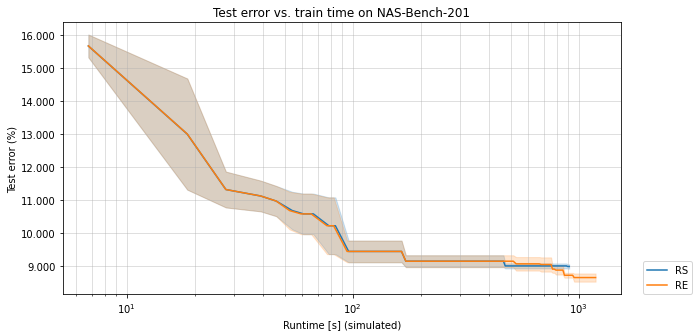

In [ ]:
# Plot RS and RE for three seeds
plot_optimizers(trajectories)

## BANANAS

In [21]:
# Bananas with 1 predictor
from naslib.search_spaces.core.query_metrics import Metric
from naslib.utils import utils, get_dataset_api
from naslib.utils.logging import setup_logger
import os
import logging
import sys
from naslib.defaults.trainer import Trainer
from naslib.optimizers import (
    DARTSOptimizer,
    GDASOptimizer,
    DrNASOptimizer,
    RandomSearch,
    RegularizedEvolution,
    LocalSearch,
    Bananas,
    BasePredictor,
)
import json
from naslib.search_spaces import (
    NasBench301SearchSpace,
    SimpleCellSearchSpace,
    NasBench201SearchSpace,
    HierarchicalSearchSpace,
)

from fvcore.common.config import CfgNode
optimizer_type = Bananas # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
predictors = ['xgb'] 
for predictor in predictors:
 for seed in [333,444,555]:
  config = {
    'search': {
        # Required by Trainer
        'epochs': 200,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        'k':20,
        "num_init":10,
        "num_ensemble":1,
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,

        # Required by BANANAS
        "predictor_type": predictor,
        "acq_fn_type": "its",
        "acq_fn_optimization": 'random_sampling',
        "encoding_type": 'path',
        "num_arches_to_mutate":5,
        "max_mutations":1,
        "num_candidates":100
     }
   }
  config = CfgNode.load_cfg(json.dumps(config))

  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed
                                                    )
  if "BANANAS_"+str(predictor) in trajectories.keys():
    trajectories["BANANAS_"+str(predictor)].append(search_trajectory)
  else: 
    trajectories["BANANAS_"+str(predictor)] = []
    trajectories["BANANAS_"+str(predictor)].append(search_trajectory)

[10/07 14:59:48 naslib]: Configuration is 
dataset: cifar10
save: runs/Bananas/NasBench201SearchSpace/cifar10/333
search:
  acq_fn_optimization: random_sampling
  acq_fn_type: its
  checkpoint_freq: 100
  encoding_type: path
  epochs: 200
  fidelity: -1
  k: 20
  max_mutations: 1
  num_arches_to_mutate: 5
  num_candidates: 100
  num_ensemble: 1
  num_init: 10
  population_size: 30
  predictor_type: xgb
  sample_size: 10
  seed: 333
[10/07 14:59:48 naslib]: Loading Benchmark API
[10/07 14:59:50 nl.defaults.trainer]: param size = 0.000000MB
[10/07 14:59:50 nl.defaults.trainer]: Start training
[10/07 14:59:52 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/07 14:59:52 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/07 14:59:52 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/07 14:59:53 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, 

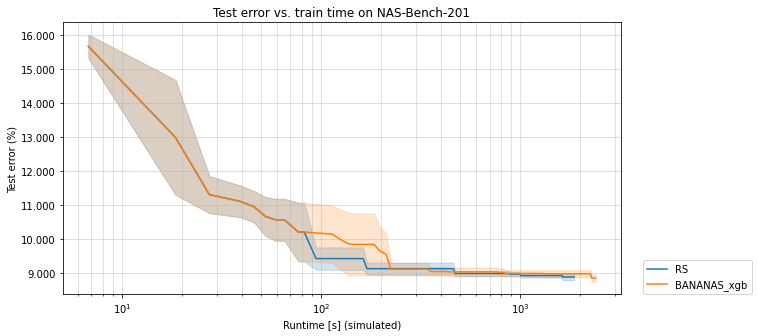

In [22]:
# Plot Bananas (xgb predictor), RS and RE
plot_optimizers(trajectories)

In [ ]:
# TODO
# 1. Run BANANAS with any predictor of your choice from ['lgb',  'rf', 'bayes_lin_reg', 'gp','mlp'] (hint: one line of code)
# 2. Use NASBench301SearchSpace with CIFAR10 dataset
optimizer_type = ...
search_space_type = ...

# Set the dataset
dataset = ... # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
predictors = [...] 
for predictor in predictors:
 for seed in [333,444,555]:
  config = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        'k':20,
        "num_init":10,
        "num_ensemble":1,
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
        "predictor_type": predictor,
        "acq_fn_type": "its",
        "acq_fn_optimization": 'random_sampling',
        "encoding_type": 'path',
        "num_arches_to_mutate":5,
        "max_mutations":1,
        "num_candidates":100
     }
   }
  config = CfgNode.load_cfg(json.dumps(config))

  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        '',
                                                        config,
                                                        seed
                                                    )
  if "BANANAS_"+str(predictor) in trajectories.keys():
    trajectories["BANANAS_"+str(predictor)].append(search_trajectory)
  else: 
    trajectories["BANANAS_"+str(predictor)] = []
    trajectories["BANANAS_"+str(predictor)].append(search_trajectory)
  

[10/07 12:21:36 naslib]: Configuration is 
dataset: cifar10
save: runs/Bananas/NasBench201SearchSpace/cifar10/333
search:
  acq_fn_optimization: random_sampling
  acq_fn_type: its
  checkpoint_freq: 100
  encoding_type: path
  epochs: 100
  fidelity: -1
  k: 20
  max_mutations: 1
  num_arches_to_mutate: 5
  num_candidates: 100
  num_ensemble: 1
  num_init: 10
  population_size: 30
  predictor_type: bayes_lin_reg
  sample_size: 10
  seed: 333
[10/07 12:21:37 naslib]: Loading Benchmark API
[10/07 12:21:38 nl.defaults.trainer]: param size = 0.000000MB
[10/07 12:21:38 nl.defaults.trainer]: Start training
[10/07 12:21:38 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/07 12:21:38 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/07 12:21:38 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/07 12:21:38 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


[10/07 12:24:30 nl.defaults.trainer]: Epoch 30 done. Train accuracy: 100.00000, Validation accuracy: 91.18000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 31 done. Train accuracy: 99.98400, Validation accuracy: 88.13000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 32 done. Train accuracy: 99.96000, Validation accuracy: 87.39000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 33 done. Train accuracy: 96.65200, Validation accuracy: 84.93000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 34 done. Train accuracy: 99.99200, Validation accuracy: 90.08000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 35 done. Train accuracy: 99.79200, Validation accuracy: 87.42000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 36 done. Train accuracy: 99.56800, Validation accuracy: 85.45000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 37 done. Train accuracy: 99.90000, Validation accuracy: 89.06000
[10/07 12:24:30 nl.defaults.trainer]: Epoch 38 done. Train accuracy: 99.91600, Validation accuracy: 88.01000
[10/07 12:24:30 nl

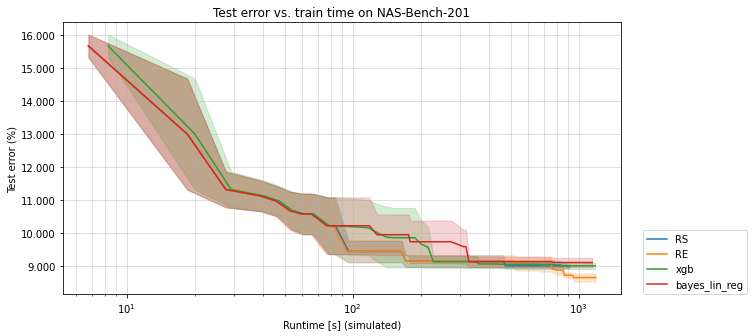

In [ ]:
plot_optimizers(trajectories)

In [23]:
from naslib.predictors import ZeroCost
from naslib.search_spaces import NasBench201SearchSpace
from naslib.utils import get_train_val_loaders, get_project_root
from fvcore.common.config import CfgNode
from tqdm import tqdm

# Create configs required for get_train_val_loaders
config = {
    'dataset': 'cifar10', # Dataset to loader: can be cifar100, svhn, ImageNet16-120, jigsaw, class_object, class_scene, or autoencoder (the last four are TNB101 datasets)
    'data': str(get_project_root()) + '/data', # path to naslib/data
    'search': {
        'seed': 9001, # Seed to use in the train, validation and test dataloaders
        'train_portion': 0.7, # Portion of train dataset to use as train dataset. The rest is used as validation dataset.
        'batch_size': 32, # batch size of the dataloaders
    }
}
config = CfgNode(config)

# Get the dataloaders
train_loader, val_loader, test_loader, train_transform, valid_transform = get_train_val_loaders(config)

# Sample a random NB201 graph and instantiate it
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
graph.parse()

# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
# {'epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params'}

zc_pred = 'l2_norm'
zc_predictor = ZeroCost(method_type=zc_pred)
score = zc_predictor.query(graph=graph, dataloader=train_loader)

print(f'Score of model for Zero Cost predictor {zc_pred}: {score}')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/NASLib/naslib/data/cifar-10-python.tar.gz to /content/NASLib/naslib/data
Files already downloaded and verified
Score of model for Zero Cost predictor l2_norm: 78.62248992919922


In [24]:
# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
zc_predictors = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

print('Scores of model')
for zc_pred in zc_predictors:
    zc_predictor = ZeroCost(method_type=zc_pred)
    score = zc_predictor.query(graph=graph, dataloader=train_loader)
    print(f'{zc_pred}: {score}')

Scores of model
epe_nas: 164.1077457677278


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fisher: 0.016749588772654533
grad_norm: 4.093494892120361
grasp: -0.15547418594360352
jacov: -732.1958061942014
l2_norm: 78.62248992919922
nwot: 305.62413411050323
plain: 0.11558683216571808
snip: 5.8311004638671875
synflow: 25.18715629598446
zen: 25.0589599609375
flops: 14.886592
params: 0.101306


In [25]:
from naslib.search_spaces.core import Metric
from naslib.utils import compute_scores, get_dataset_api

# Sample 50 random architectures, query their performances
n_graphs = 50
models = []
val_accs = []
zc_scores = []

print('Loading NAS-Bench-201 API...')
api = get_dataset_api('nasbench201', 'cifar10')

print(f'Sampling {n_graphs} NAS-Bench-201 models...')
for _ in tqdm(range(n_graphs)):
    graph = NasBench201SearchSpace()
    graph.sample_random_architecture()
    graph.parse()

    models.append(graph)

print('Querying validation performance for all models')
for graph in tqdm(models):
    acc = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=api)
    val_accs.append(acc)

zc_predictor = ZeroCost(method_type='jacov')

print('Scoring the models using Zero Cost predictor (jacov)')
for graph in tqdm(models):
    score = zc_predictor.query(graph, dataloader=train_loader)
    zc_scores.append(score)

correlations = compute_scores(ytest=val_accs, test_pred=zc_scores)
kendalltau_corr = correlations['kendalltau']
spearman_corr = correlations['spearman']
pearson_corr = correlations['pearson']

print('*'*50)
print('Validation accuracies: ', val_accs)
print()
print('Zero Cost predictor scores: ', zc_scores)
print('*'*50)
print('Correlations between validation accuracies (ground truth) and Zero Cost predictor scores (prediction): ')
print('Kendall Tau correlation:', kendalltau_corr)
print('Spearman correlation:', spearman_corr)
print('Pearson correlation:', pearson_corr)

Loading NAS-Bench-201 API...


  2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

Sampling 50 NAS-Bench-201 models...


  0%|          | 0/50 [00:00<?, ?it/s]

Querying validation performance for all models
Scoring the models using Zero Cost predictor (jacov)


100%|██████████| 50/50 [02:50<00:00,  3.40s/it]

**************************************************
Validation accuracies:  [85.57, 88.93, 70.6, 85.41, 88.89, 88.5, 86.11, 84.08, 84.21, 71.96, 88.23, 90.25, 85.36, 78.78, 85.47, 78.99, 83.3, 89.24, 87.51, 71.41, 87.75, 85.98, 87.97, 86.52, 80.38, 89.06, 88.43, 85.09, 33.93, 83.85, 89.05, 88.79, 78.37, 88.29, 86.28, 89.08, 86.96, 88.53, 84.19, 88.49, 90.75, 84.31, 87.6, 89.28, 87.02, 85.23, 89.17, 90.08, 89.5, 88.31]

Zero Cost predictor scores:  [-33.291100498624075, -32.29599484014209, -94.98418356010305, -32.62873185165185, -32.3161657935061, -32.28893233140842, -32.265640519500494, -32.39019563161993, -51.477815285362446, -100.7809546541518, -32.41696876963438, -32.34137167057058, -32.42607871195703, -57.62471045084263, -34.89575492803915, -45.72505169783978, -115.25948626161286, -32.31112232957404, -32.29893050096213, -85.31503943491052, -36.07475982049287, -32.28069872685221, -32.317887633225624, -32.3767410000947, -84.40523117243868, -32.305632597387174, -33.4415509762117, -45.6

In [26]:
%ls
%cd NASLib
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201

docs/      naslib/           runs/      test_benchmark_apis.py
examples/  naslib.egg-info/  scripts/   tests/
images/    README.md         setup.cfg  tutorial/
LICENSE    requirements.txt  setup.py
[Errno 2] No such file or directory: 'NASLib'
/content/NASLib
search_space = nb201
nb201 file exist


In [27]:
from naslib.utils import get_zc_benchmark_api

zc_api = get_zc_benchmark_api('nasbench201', 'cifar10')
graph = models[0]

# Use the Zero Cost Benchmark to get the score for the model for a particular ZC proxy
pred = 'grasp'
spec = graph.get_hash()
score = zc_api[str(spec)][pred]['score']
time_to_compute = zc_api[str(spec)][pred]['time']

print(f'Score of model with spec {spec} for Zero Cost predictor {pred}: {score}')
print(f'Time taken to compute the score for the model: {time_to_compute:.2f}s')

Score of model with spec (2, 0, 0, 3, 0, 0) for Zero Cost predictor grasp: -0.016125619411468506
Time taken to compute the score for the model: 2.28s


In [28]:
zc_scores = {pred: [] for pred in zc_predictors} # Just dictionary of an empty list for each predictor
print('zc_scores:', zc_scores)

print('Querying Zero Cost Benchmark for scores')
for graph in tqdm(models):
    spec = graph.get_hash()

    # Get the score for this model for all the Zero Cost predictors
    for pred in zc_predictors:
        score = zc_api[str(spec)][pred]['score']
        zc_scores[pred].append (score)

# Print the Zero Cost values for the first 5 models
for pred in zc_predictors:
    print(pred, zc_scores[pred][:5])

kt_corrs = {}
# Compute the rank correlation for each of the predictors
for pred in zc_predictors:
    correlations = compute_scores(ytest=val_accs, test_pred=zc_scores[pred])
    kendalltau_corr = correlations['kendalltau']
    kt_corrs[pred] = kendalltau_corr

print('Kendall-Tau correlations for all the predictors:')
print(kt_corrs)
# Sort the predictors from best to worst for these models
kt_corrs_list = [(pred, score) for pred, score in kt_corrs.items()]
kt_corrs_list = sorted(kt_corrs_list, reverse=True, key=lambda pred_score_tuple: pred_score_tuple[1])

print('ZC predictors ranked (best to worst):')
for idx, (pred, score) in enumerate(kt_corrs_list):
    print(f'#{idx+1}', pred, score)

100%|██████████| 50/50 [00:00<00:00, 12061.61it/s]

zc_scores: {'epe_nas': [], 'fisher': [], 'grad_norm': [], 'grasp': [], 'jacov': [], 'l2_norm': [], 'nwot': [], 'plain': [], 'snip': [], 'synflow': [], 'zen': [], 'flops': [], 'params': []}
Querying Zero Cost Benchmark for scores
epe_nas [1292.8213521234534, 1677.4133181362522, 771.6244256973021, 1737.454440152671, 1573.3680969091486]
fisher [0.0032408733386546373, 0.6351345181465149, 0.036273304373025894, 0.04645204544067383, 1.5173672437667847]
grad_norm [1.9650213718414307, 72.5101547241211, 7.580556869506836, 16.29119300842285, 126.30833435058594]
grasp [-0.016125619411468506, -3.2642059326171875, -0.06577873229980469, 4.319438457489014, 157.290771484375]
jacov [-72.90912838633159, -65.15828505076317, -311.63863660167726, -65.98522306098099, -65.11022856424916]
l2_norm [129.5747528076172, 231.27603149414062, 78.764892578125, 180.98062133789062, 282.43365478515625]
nwot [756.8241446485636, 789.6434823031072, 611.1394665263265, 782.2980597435335, 818.9739002527507]
plain [0.0644750222